<a href="https://colab.research.google.com/github/JINSUNGWOO/section2_project/blob/main/AI_11_%EC%9A%B0%EC%A7%84%EC%84%B1_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

분류가 아닌 회귀로 풀어야하는지,

풀고나서 라벨링 데이터에 맞추어 볼때, groupby('id')를 사용하고 테스트를 진행했어야하는지

# 헬스케어 웨어러블 기반 치매 고위험군 병리진단으로 정의된 치매진행 라이프로그 학습용 데이터 

(광주광역시)

연구대상자 : 광주광역시 내 거주자 300명 (정상:150명, 치매 위험군: 150명)

50대: 4명, 60대: 63명, 70대: 193명, 80대이상:40명

남자: 137명, 여자: 163명

*샘플데이터 16명에대한 정보

필요성:
- 고령화 사회로의 진입 및 치매 발병률 증가에 따른 의료비 부담 증가로 인해 치매 환자의 조기진단과 치료가 중요한 과제로 부상
- 치매조기진단 예측 및 발병의 예방과 선제적 관리를 위한 AI 기술개을 위하여 검증된 학습용 데이터를 구축하고자 함

중요 칼럼:
- activity_score: 활동점수
- sleep_score: 수면점수
- TOTAL: 총점

진단결과:
- CN: 정상
- MCI: 경도인지장애
- Dem: 치매


## 머신러닝 프로세스
Wrangling한 데이터를 train_test_split 후, 검증데이터를 통해 LinearRegressor, Ensemble모델인 RandomForestRegression, RandomForestClassifier를 사용하여 모델의 평가지표를 측정한다.

측정한 데이터를 라벨링데이터에 맞추어 비교한다.
- 라벨링데이터: id별로 치매의 정도를 나타내고 있다.
- 데이터들을 종합하여 groupby로 묶은 후 평가

In [ ]:
! pip install category_encoders
! pip install pdpbox
! pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from category_encoders import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
import xgboost

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint, uniform
import warnings

warnings.simplefilter(action='ignore')

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [171]:
activity = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/원천데이터/1.걸음거리/sample_activity.csv')
sleep = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/원천데이터/2.수면/sample_sleep.csv')
mmse = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/원천데이터/3.인지기능/sample_mmse.csv')

In [172]:
def undergo(data):
  # replace
  data.columns = data.columns.str.lower()
  data.columns = data.columns.str.replace('sleep_','')
  data.columns = data.columns.str.replace('activity_','')
  
  # split
  data[['id','domain']] = data['email'].str.split('@', expand=True)
  data[['nia','id']]  = data['id'].str.split('+',expand=True)
  
  # drop
  data.drop(columns=['nia','email','domain'],axis=1, inplace=True)
  data.drop((x for x in data.columns if ('convert' in x or '5min' in x or 'met_min' in x or 'day' in x)),axis=1,inplace=True)
  
  # sequence
  #col_list = ['id','score','total']
  #data=data[col_list]
  return data

def undergone(df):
  # replace
  df.columns = df.columns.str.lower()
  df.columns = df.columns.str.replace('sample_','')
  df.columns = df.columns.str.replace('total','mmse_total')

  # split
  df[['id','domain']] = df['email'].str.split('@', expand=True)
  df[['nia','id']]  = df['id'].str.split('+',expand=True)

  # drop
  df.drop(columns= ['email','domain','nia'],axis=1,inplace=True)
  #df.columns = df.columns[::-1]
  df = df.iloc[:,-2:]
  return df



go_act = undergo(activity)
go_sleep = undergo(sleep)

go_mmse = undergone(mmse)
go_mmse = go_mmse.iloc[:,::-1]

In [173]:
drop_cols =['high','inactive','inalerts','non_wear','rest','score_move_every_hour']
go_act.drop(drop_cols,axis=1,inplace=True)

save_cols = ['deep','duration','efficiency','light','midpoint_time','rem','total']
score_cols = [x for x in go_sleep.columns if 'score' in x]
sleep_cols = save_cols + score_cols
go_sleep = pd.DataFrame(go_sleep,columns=sleep_cols)

go_sleep.rename(columns={'total':'sleep_total', 'score':'sleep_score'},inplace=True)
go_act.rename(columns={'total':'act_total', 'score':'act_score'},inplace=True)

go_act.drop(['low','average_met','score_recovery_time'],axis=1,inplace=True)
go_sleep.drop(['duration','score_total'],axis=1,inplace=True)

In [174]:
go_df = pd.concat([go_sleep, go_act], axis=1)

In [175]:
go_df.nunique().sort_values(ascending=False) # high cardinality 존재하나 continuos한 데이터 
go_df.drop('met_1min',axis=1,inplace=True) # 신호column 삭제
go_df.columns.duplicated().sum() # 중복된 이름의 column 없음, 결측치 없음
go_df['sum_score'] = go_df['act_score'] + go_df['sleep_score'] # target결정

In [197]:
label = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/라벨링데이터/1.걸음거리/sample_label.csv')
id_df = pd.DataFrame(go_df.groupby('id').sum_score.agg('mean'))
id_df = id_df.reset_index()
final_df = pd.merge(id_df,go_mmse,on='id')
label = undergone(label)
real = pd.merge(final_df,label,on='id')
real.sort_values(by='diag_nm')

,id,sum_score,mmse_total,diag_nm
1,041,167.916667,29,CN
5,118,162.790323,30,CN
6,141,176.623188,30,CN
8,181,148.209677,26,CN
9,188,169.615385,27,CN
13,343,168.467742,28,CN
14,354,154.122807,26,CN
15,438,163.860465,27,CN
2,067,145.186667,16,Dem
0,016,161.955224,28,MCI


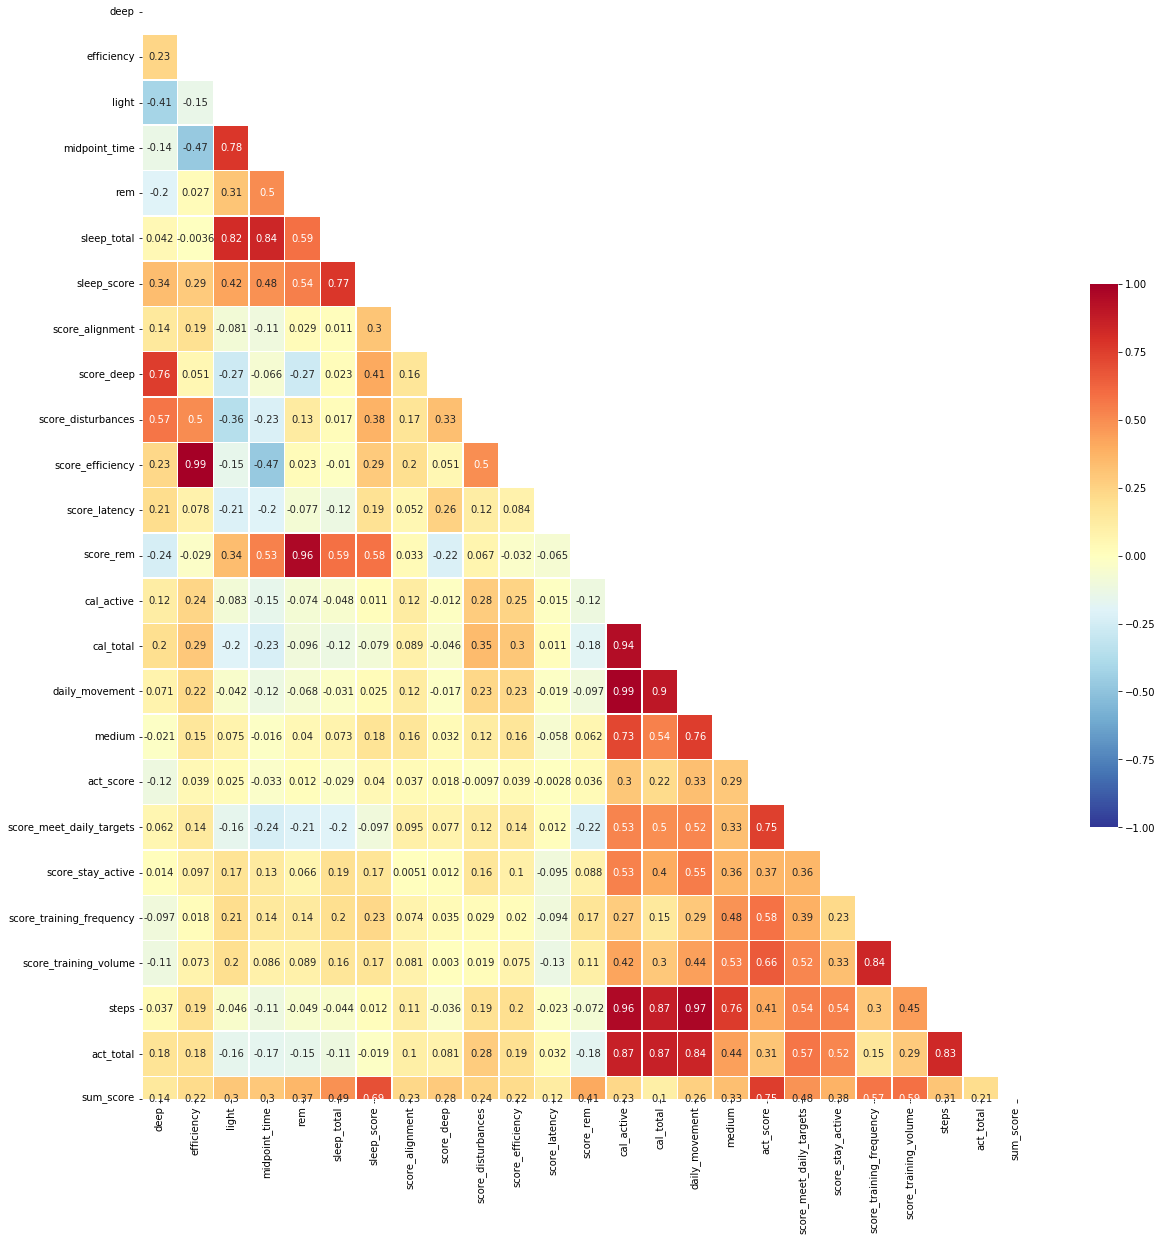

In [177]:
fig, ax = plt.subplots( figsize=(20,20) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(go_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(go_df.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show();

In [187]:
go_df.drop(['sleep_score','act_score'],axis=1,inplace=True)

KeyError: ignored

-0.5044086579083189


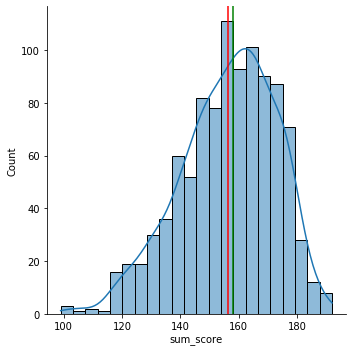

In [178]:
print(go_df['sum_score'].skew())

sns.displot(go_df['sum_score'], kde = True)

plt.axvline(go_df['sum_score'].mean(), color = 'r')
plt.axvline(go_df['sum_score'].median(), color = 'g'); # Negative Skewness, 

In [188]:
target = 'sum_score'

train, test = train_test_split(go_df, train_size=0.80, test_size=0.20, random_state=42)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [189]:
X_train.shape, X_val.shape

((640, 23), (160, 23))

In [128]:
pipe = make_pipeline(
    OrdinalEncoder()
    , StandardScaler()
    , RandomForestRegressor(random_state=42)
    )


dists = {
    'randomforestregressor__n_estimators': randint(100, 500) # 209
    , 'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'poisson'] # squared_error
    , 'randomforestregressor__max_depth': [5,10,15,20,None] # 20
}


clf = RandomizedSearchCV(
      pipe
    , param_distributions=dists
    , n_iter=5
    , cv=3
    , scoring='r2'
    , verbose=2
)

pipe.fit(X_train, y_train);
clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END randomforestregressor__criterion=poisson, randomforestregressor__max_depth=None, randomforestregressor__n_estimators=303; total time=  15.0s
[CV] END randomforestregressor__criterion=poisson, randomforestregressor__max_depth=None, randomforestregressor__n_estimators=303; total time=   9.6s
[CV] END randomforestregressor__criterion=poisson, randomforestregressor__max_depth=None, randomforestregressor__n_estimators=303; total time=  10.3s
[CV] END randomforestregressor__criterion=squared_error, randomforestregressor__max_depth=15, randomforestregressor__n_estimators=158; total time=   1.4s
[CV] END randomforestregressor__criterion=squared_error, randomforestregressor__max_depth=15, randomforestregressor__n_estimators=158; total time=   1.4s
[CV] END randomforestregressor__criterion=squared_error, randomforestregressor__max_depth=15, randomforestregressor__n_estimators=158; total time=   1.3s
[CV] END randomforestregress

In [131]:
best_pipe = clf.best_estimator_
best_pipe.fit(X_train, y_train);

print('Validation R^2:', round(best_pipe.score(X_val,y_val),3))

y_pred = best_pipe.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)

print('Test Score:', round(best_pipe.score(X_test, y_test),3))


Validation R^2: 0.86
Test Score: 0.807


In [132]:
linear_model = make_pipeline(
    OrdinalEncoder()
    , StandardScaler()
    , LinearRegression()
    )


linear_model.fit(X_train, y_train);

print('Validation R^2:', round(linear_model.score(X_val,y_val),3))

y_pred = linear_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)

print('Test Score:', round(linear_model.score(X_test, y_test),3))


Validation R^2: 0.879
Test Score: 0.876


In [133]:
rfc = make_pipeline(
    OrdinalEncoder()
    , StandardScaler()
    , RandomForestClassifier(random_state=42,oob_score=True)
    )


dists = {
    'randomforestclassifier__n_estimators': randint(100, 500) # 269
    , 'randomforestclassifier__max_features': ['sqrt', 'log2'] # sqrt
    , 'randomforestclassifier__max_depth': [5,10,15,20,None] # 20
}


clf = RandomizedSearchCV(
      rfc
    , param_distributions=dists
    , n_iter=5
    , cv=3
    , scoring='accuracy'
    , verbose=2
)

rfc.fit(X_train, y_train);
clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END randomforestclassifier__max_depth=20, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=419; total time=   2.0s
[CV] END randomforestclassifier__max_depth=20, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=419; total time=   1.9s
[CV] END randomforestclassifier__max_depth=20, randomforestclassifier__max_features=log2, randomforestclassifier__n_estimators=419; total time=   1.9s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=471; total time=   1.5s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=471; total time=   1.4s
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=471; total time=   1.4s
[CV] END randomforestclassifier__max_

In [134]:
best_rfc = clf.best_estimator_
best_rfc.fit(X_train, y_train);

print('Validation R^2:', round(best_rfc.score(X_val,y_val),3))

y_pred = best_rfc.predict(X_test)
print('Test Score:', round(best_rfc.score(X_test, y_test),3))
print(classification_report(y_test,y_pred))

Validation R^2: 0.056
Test Score: 0.075
              precision    recall  f1-score   support

         103       0.00      0.00      0.00         1
         117       0.33      1.00      0.50         1
         120       0.00      0.00      0.00         1
         121       0.00      0.00      0.00         1
         123       0.00      0.00      0.00         1
         124       0.00      0.00      0.00         1
         125       0.00      0.00      0.00         1
         126       0.00      0.00      0.00         1
         127       0.00      0.00      0.00         1
         128       0.00      0.00      0.00         3
         129       0.00      0.00      0.00         2
         130       0.00      0.00      0.00         2
         131       0.00      0.00      0.00         1
         132       0.00      0.00      0.00         1
         133       0.00      0.00      0.00         2
         134       0.00      0.00      0.00         1
         135       0.33      0.50      0.

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [181]:
X_test.columns

Index(['deep', 'efficiency', 'light', 'midpoint_time', 'rem', 'sleep_total',
       'sleep_score', 'score_alignment', 'score_deep', 'score_disturbances',
       'score_efficiency', 'score_latency', 'score_rem', 'cal_active',
       'cal_total', 'daily_movement', 'medium', 'act_score',
       'score_meet_daily_targets', 'score_stay_active',
       'score_training_frequency', 'score_training_volume', 'steps',
       'act_total', 'id'],
      dtype='object')

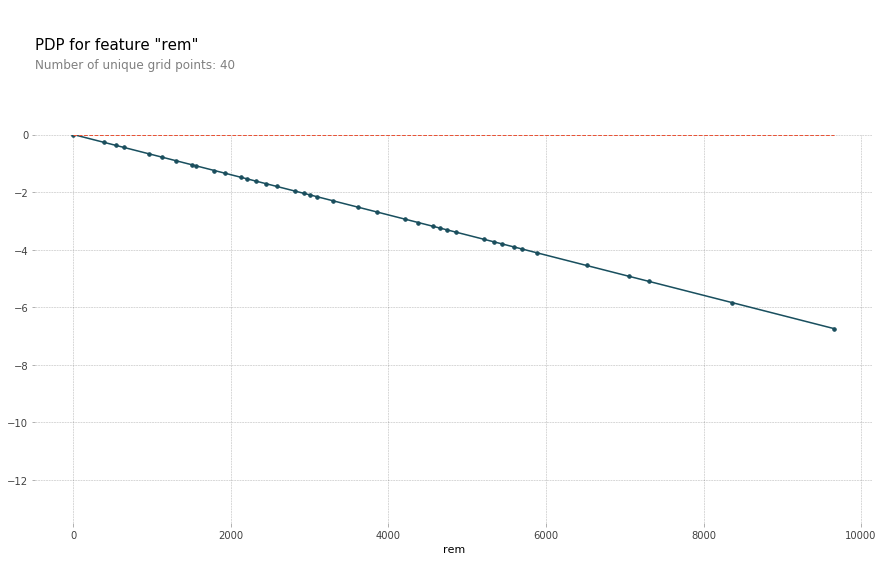

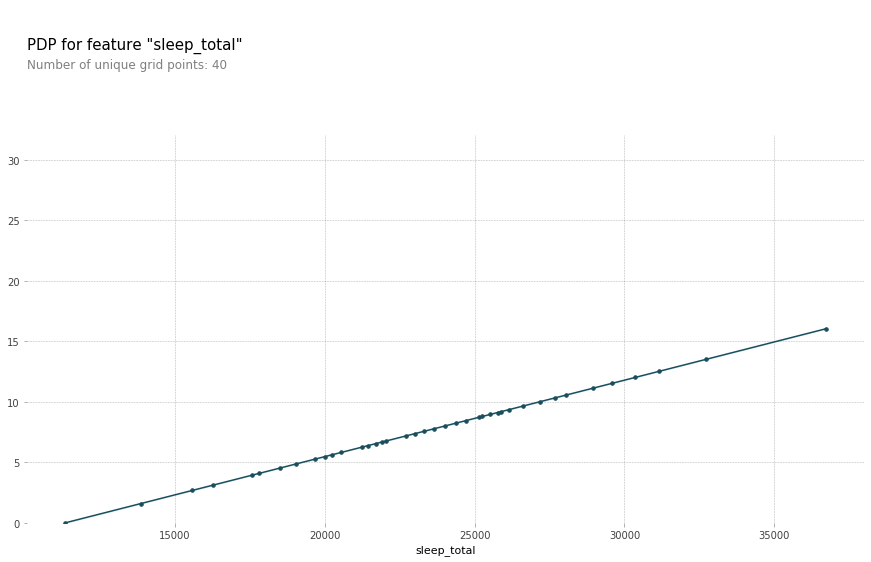

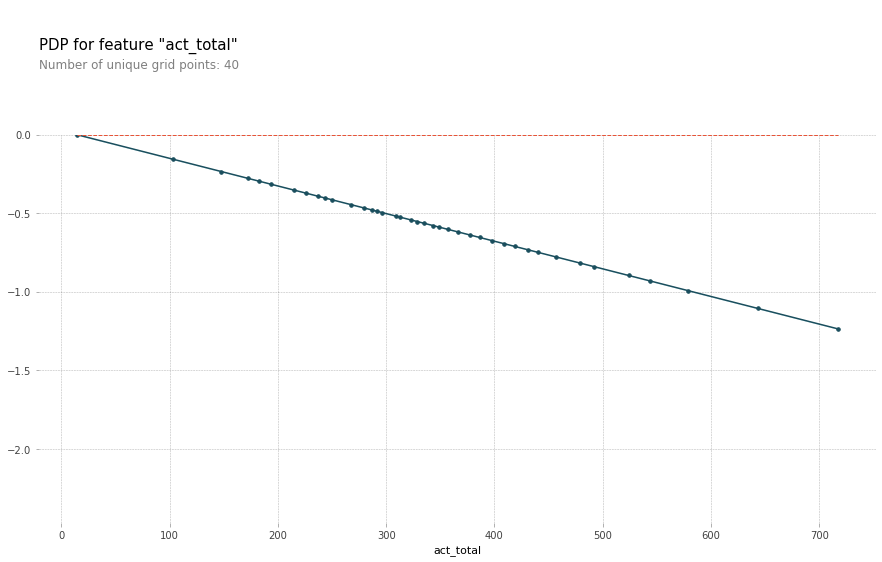

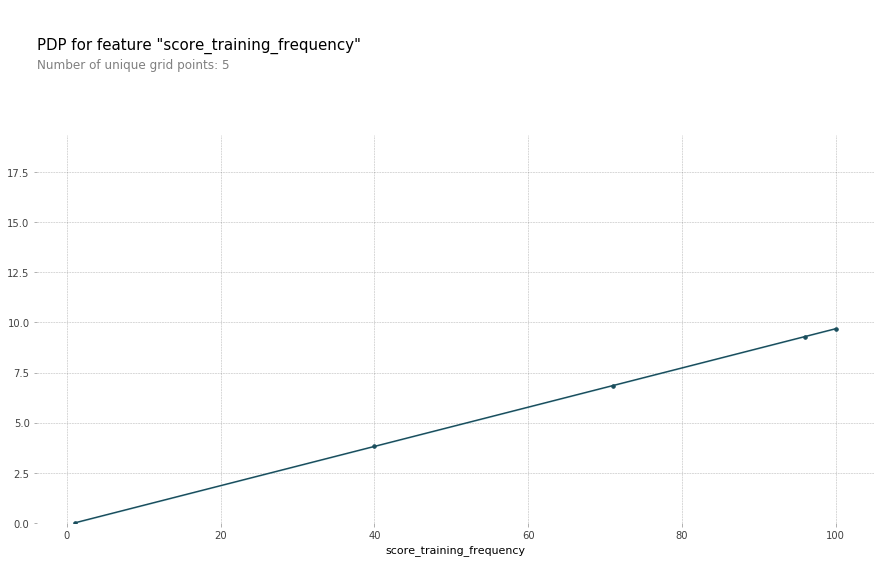

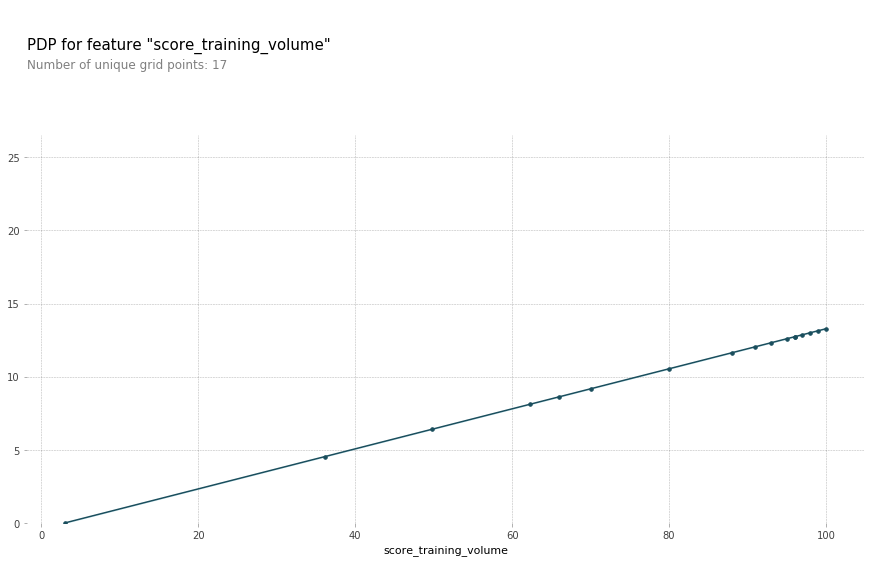

In [144]:
features = ['rem','sleep_total','act_total','score_training_frequency','score_training_volume']

linear = LinearRegression().fit(X_train,y_train)

for feature in features:
    isolated = pdp_isolate(
        model=linear, 
        dataset=X_test, 
        model_features=X_test.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=40 # default=10
    )
    pdp_plot(isolated, feature_name=feature);

In [ ]:

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) 
X_test_encoded = encoder.transform(X_test) 

boosting = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=100
         )


In [ ]:
y_pred = boosting.predict(X_test_encoded)
print('R^2', r2_score(y_test, y_pred))

R^2 0.9886571402549622


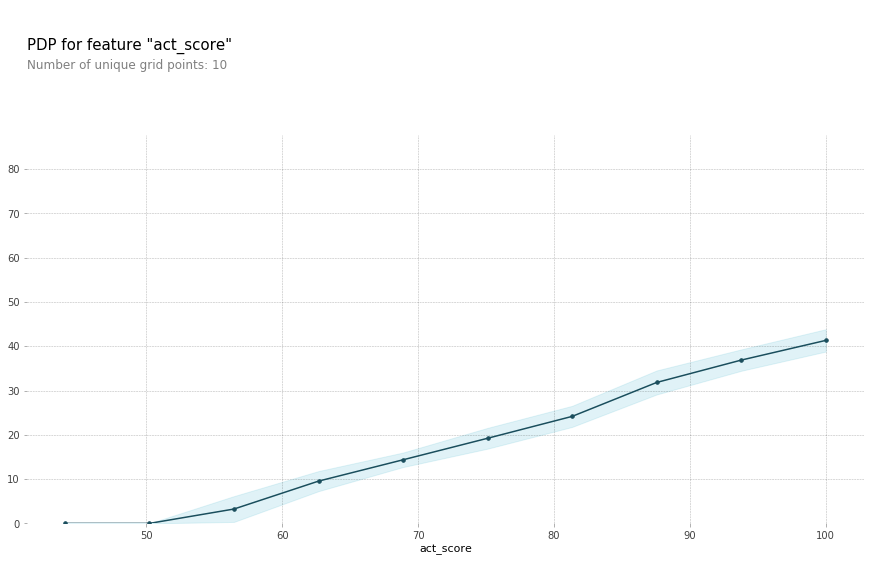

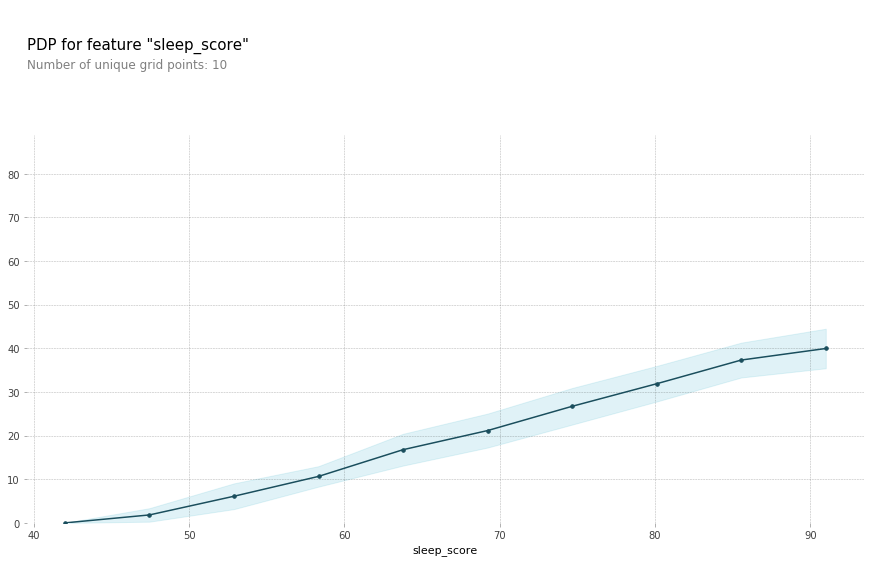

In [183]:
two = ['act_score','sleep_score']
for feature in two:
  isolated = pdp_isolate(
    model=boosting, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature,
    grid_type='equal', 
    num_grid_points=10
  )
  pdp_plot(isolated, feature_name=feature); 

In [ ]:
label = pd.read_csv('/content/drive/MyDrive/dataset/2020-02-128.치매고위험군_sample/라벨링데이터/1.걸음거리/sample_label.csv')
go_label = undergone(label)
go_label
finish_df = pd.merge(go_label, final_df,on='id')
finish_df = finish_df[['id','mmse_total','sum_score','diag_nm']]
finish_df.sum_score=finish_df.sum_score.astype(int)
data = finish_df.sort_values(by='id',ascending=True)
data.reset_index(drop=True,inplace=True)

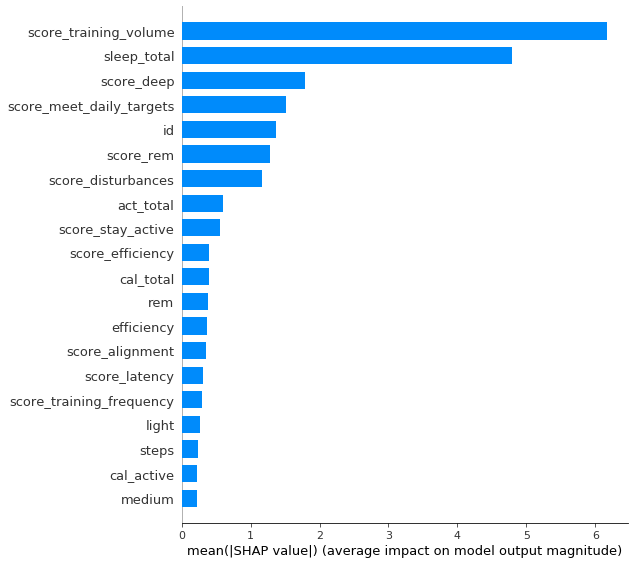

In [190]:
X_1 = y_train > 150
rfr = RandomForestRegressor(criterion= 'squared_error', max_depth= 20, n_estimators= 192, random_state=42, n_jobs=-1)
rfr.fit(X_train,y_train)
shap_values = shap.TreeExplainer(rfr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

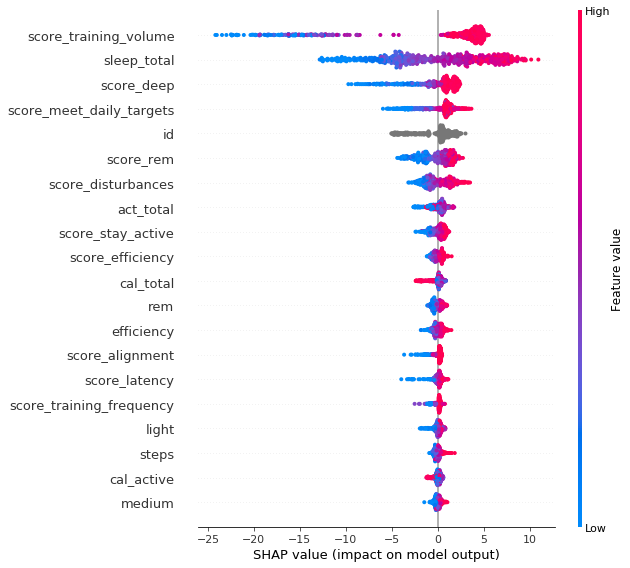

In [166]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

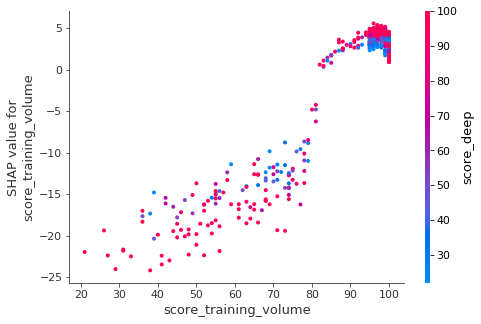

In [167]:
shap.dependence_plot('score_training_volume', shap_values, X_train)